In [1]:
import numpy as np
from numpy import abs, sqrt, log10, sin, cos, exp, cosh, tanh, log, conj, cosh, sinh
np.set_printoptions(precision=16)
from math import pi, factorial
from numpy.random import rand
from numpy.linalg import norm
import scipy
import scipy.sparse as sp
from scipy.sparse import linalg, csc_matrix
import time
from scipy.optimize import minimize
from scipy.special import eval_hermite

%matplotlib inline
import matplotlib.pyplot as plt
%config InlineBackend.figure_format ="retina"
import matplotlib as mpl
#mpl.rcParams["figure.dpi"] = 
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

import pickle

from qonn_cobyla import *

from qutip import *

import matplotlib as mpl

from matplotlib import cm

from scipy.signal import argrelextrema, find_peaks
from scipy.optimize import curve_fit

In [2]:
def QFI(psi):
    '''
    This function computes the quantum Fisher information of the pure state psi.
    '''
    
    # Encoding (MZ interferometer)
    psi_phi = oc.eval_rho_interf(phi, psi)
    psi_delta = oc.eval_rho_interf(phi_delta, psi)

    # Evaluate QFI
    F = np.abs(psi_phi[np.newaxis, :].conj() @ psi_delta[:, np.newaxis])
    cost = (8*(1-F)/oc.delta**2)[0][0]

    return cost

In [3]:
def get_rho(psi):
    '''
    This function computes the density matrix of the first mode (by tracing out the emitters and the second mode).
    Input: total pure state psi.
    '''

    # We trace out the emitters
    rho = psi[:, np.newaxis] @ psi[np.newaxis, :].conj()
    basis_c = csc_matrix(np.eye((N_p+1)**2, dtype=np.complex128))
    basis_e = csc_matrix(np.eye(2**2, dtype=np.complex128))
    rho_c = 0 # Initialize reduced density matrix of mode 1
    for j in range(2**2):
        rho_c += sp.kron(basis_e[:, j].H, basis_c) @ rho @ sp.kron(basis_e[:, j], basis_c)

    # We trace out the second mode
    basis_1 = csc_matrix(np.eye(N_p+1, dtype=np.complex128))
    basis_2 = csc_matrix(np.eye(N_p+1, dtype=np.complex128))
    rho_1 = 0 # Initialize reduced density matrix of mode 1
    for j in range(N_p+1):
        rho_1 += sp.kron(basis_2[:, j].H, basis_1) @ rho_c @ sp.kron(basis_2[:, j], basis_1)

    return rho_1

In [4]:
def QFI_explicit(psi):
    '''
    This function calculates the QFI of the pure state psi.
    '''

    psi_phi = np.copy(psi)
    # Encoding (MZ interferometer)
    psi_phi = sp.linalg.expm_multiply(-1j * (0*sp.eye(setup.d, dtype=np.complex128) + setup.H_BS_sym_ec()), psi_phi)
    psi_phi = sp.linalg.expm_multiply(-1j * (phi[1] * setup.H_phi_ec() ), psi_phi)
    psi_phi = sp.linalg.expm_multiply(-1j * (0*sp.eye(setup.d, dtype=np.complex128) + setup.H_BS_sym_ec()), psi_phi)
    
    psi_delta = np.copy(psi)
    # Encoding (MZ interferometer)
    psi_delta = sp.linalg.expm_multiply(-1j * (0*sp.eye(setup.d, dtype=np.complex128) + setup.H_BS_sym_ec()), psi_delta)
    psi_delta = sp.linalg.expm_multiply(-1j * (phi_delta[1] * setup.H_phi_ec() ), psi_delta)
    psi_delta = sp.linalg.expm_multiply(-1j * (0*sp.eye(setup.d, dtype=np.complex128) + setup.H_BS_sym_ec()), psi_delta)

    # Evaluate QFI
    F = np.abs(psi_phi[np.newaxis, :].conj() @ psi_delta[:, np.newaxis])
    cost = (8*(1-F)/oc.delta**2)[0][0]

    return cost

In [5]:
def get_wigner(psi):
    '''
    This function gets the Wigner quasiprobability distribution of the pure state psi (in QuTiP).
    '''

    # We trace out the emitters
    rho = psi[:, np.newaxis] @ psi[np.newaxis, :].conj()
    basis_c = csc_matrix(np.eye((N_p+1)**2, dtype=np.complex128))
    basis_e = csc_matrix(np.eye(2**2, dtype=np.complex128))
    rho_c = 0 # Initialize reduced density matrix of mode 1
    for j in range(2**2):
        rho_c += sp.kron(basis_e[:, j].H, basis_c) @ rho @ sp.kron(basis_e[:, j], basis_c)

    # We trace out the second mode
    basis_1 = csc_matrix(np.eye(N_p+1, dtype=np.complex128))
    basis_2 = csc_matrix(np.eye(N_p+1, dtype=np.complex128))
    rho_1 = 0 # Initialize reduced density matrix of mode 1
    for j in range(N_p+1):
        rho_1 += sp.kron(basis_2[:, j].H, basis_1) @ rho_c @ sp.kron(basis_2[:, j], basis_1)

    rho_1_qutip = Qobj(rho_1)
    xvec = np.linspace(-sqrt(N_p), sqrt(N_p), 200)
    W_1 = wigner(rho_1_qutip, xvec, xvec)

    return W_1

### Panel (a)

In [6]:
N_p = 40

N_e = 2
N_c = 2
d = 2
layers_p = d
layers_m = d

phi = [0, pi/3, 0]
delta = 1e-2
phi_delta = [0, pi/3 + delta, 0]

setup = Setup(N_e, N_c, N_p)
oc = JCMeasCircuit(setup, layers_p, layers_m, delta)

# Initial state: coherent state (up to an N_p/2 threshold in each mode)
alpha = sqrt(N_p/4)
psi_coh = 0.0
for n in range(int(N_p + 1)):
    cavity = np.zeros(N_p + 1, dtype=np.complex128)
    cavity[n] = 1.0
    psi_coh += alpha**n/sqrt(float(factorial(n)))*cavity
psi_coh = exp(-abs(alpha)**2/2) * psi_coh
psi_coh = psi_coh / sqrt(np.real(psi_coh[np.newaxis, :].conj() @ psi_coh[:, np.newaxis]))[0][0]
psi_0 = np.kron(psi_coh, psi_coh)

# Initial state: emitters in ground state
emitter = np.array([1, 0], dtype=np.complex128)
emitters = 1.0
for i in range(N_e):
    emitters = np.kron(emitters, emitter)

psi_0 = np.kron(emitters, psi_0)

In [7]:
# We compute the QFI, the Wigner quasiprobability distribution, and the reduced density matrix of the first mode
rho_t = []
QFI_t = []
Pe_t = []
Pg_t = []

t_vec = np.linspace(0, 35, 50)

for i, t in enumerate(t_vec):

    print('{:}/{:}'.format(i+1, len(t_vec)))

    psi = np.copy(psi_0)
    psi = sp.linalg.expm_multiply(-1j * t * setup.H_int(), psi)
    
    rho_t.append(get_rho(psi))
    QFI_t.append(QFI_explicit(psi))

1/50
2/50
3/50
4/50
5/50
6/50
7/50
8/50
9/50
10/50
11/50
12/50
13/50
14/50
15/50
16/50
17/50
18/50
19/50
20/50
21/50
22/50
23/50
24/50
25/50
26/50
27/50
28/50
29/50
30/50
31/50
32/50
33/50
34/50
35/50
36/50
37/50
38/50
39/50
40/50
41/50
42/50
43/50
44/50
45/50
46/50
47/50
48/50
49/50
50/50


15.714285714285715


(0.002, 0.05500000000000001)

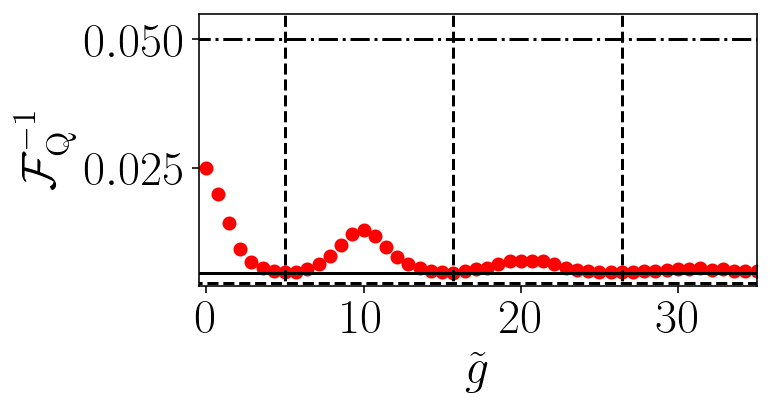

In [11]:
# Time index at which the displaced cat state is formed (first minima)
i_cat = argrelextrema(1/np.array(QFI_t), np.less)[0][0]

# Time for formation of the displaced Fock state according to our results
i_fock = 37

# We plot the ultimate estimation error given by the QFI
plt.rcParams["figure.figsize"] = [5, 2.5]
fig, ax = plt.subplots(1, 1)
marker_size = 80
fs = 24
xticks = np.arange(0, 40, 10)
xlims = [-0.5, 35]
lw = 2

N = N_p/2
alpha = sqrt(N_p/4)
t_r = 2*pi*alpha

ax.scatter(t_vec, 1/np.array(QFI_t), color='r')

N = N_p/2
ax.plot([min(t_vec)-1, max(t_vec)+1], [1/N, 1/N], '-.k', label='SQL')
ax.plot([min(t_vec)-1, max(t_vec)+1], [2/(N*(N+2)), 2/(N*(N+2))], '-k', label='TFS')
ax.plot([min(t_vec)-1, max(t_vec)+1], [1/N**2, 1/N**2], '--k', label='HL')

ax.plot([t_vec[i_cat], t_vec[i_cat]], [-1, 2/N], '--k')
ax.plot([t_vec[i_fock], t_vec[i_fock]], [-1, 2/N], '--k')
ax.plot([t_vec[22], t_vec[22]], [-1, 2/N], '--k')
print(t_vec[22])

ax.set_xticks(xticks)
ax.set_xlim(xlims[0], xlims[1])
ax.set_xlabel(r'$\tilde{g}$',fontsize=fs)
ax.set_ylabel(r'$\mathcal{F}^{-1}_{\rm Q}$',fontsize=fs)
ax.tick_params(axis='both', labelsize=fs)
ax.set_ylim(0.8/N**2, 1.1/N)

### Panels (b) and (c)

In [ ]:
# We plot the Wigner
xvec = np.linspace(-sqrt(N_p), sqrt(N_p), 200)
W_t = [wigner(Qobj(rho), xvec, xvec, g=2) for rho in rho_t]

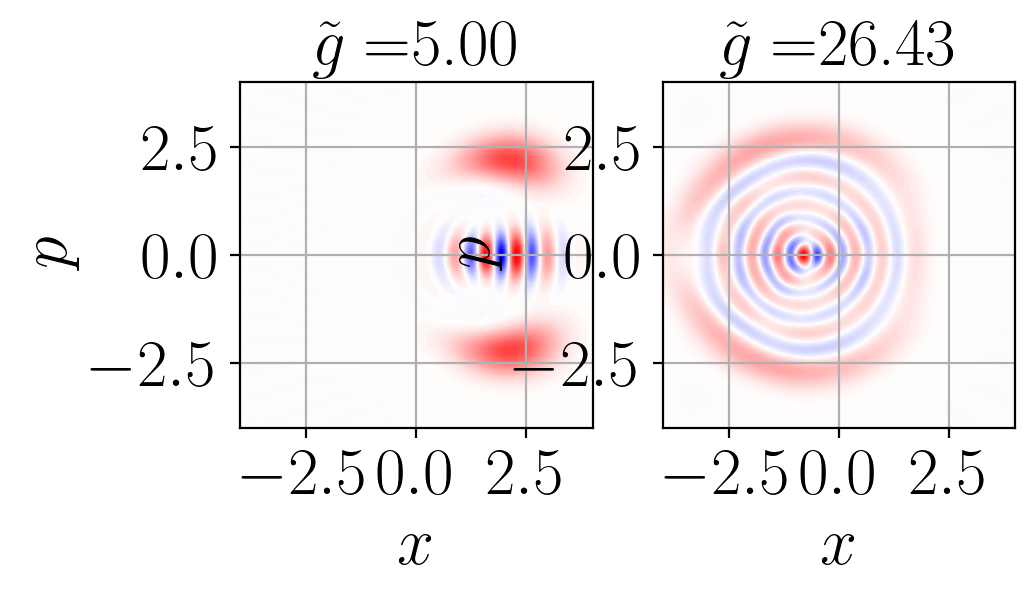

In [ ]:
plt.rcParams["figure.figsize"] = [5, 2.25]
fig, ax = plt.subplots(1, 2)
marker_size = 80
fs = 24
#xticks = np.arange(0, 40, 10)
#xlims = [-1, 35]
lw = 2

i_cat = argrelextrema(1/np.array(QFI_t), np.less)[0][0]
#i_cat = 22

nrm = mpl.colors.Normalize(-W_t[i_cat].max(), W_t[i_cat].max())
cp = ax[0].contourf(xvec, xvec, W_t[i_cat], 100, cmap=cm.bwr, norm=nrm)
ax[0].grid()
#ax[0].set_xticklabels([])
ax[0].set_xlabel(r'$x$', fontsize=fs)
ax[0].set_ylabel(r'$p$', fontsize=fs)
ax[0].tick_params(axis='both', labelsize=fs)
ax[0].set_title(r'$\tilde{g}=$'+'{:.2f}'.format(t_vec[i_cat]), fontsize=fs)

nrm = mpl.colors.Normalize(-W_t[i_fock].max(), W_t[i_fock].max())
cp = ax[1].contourf(xvec, xvec, W_t[i_fock], 100, cmap=cm.bwr, norm=nrm)
ax[1].grid()
ax[1].set_xlabel(r'$x$', fontsize=fs)
ax[1].set_ylabel(r'$p$', fontsize=fs)
ax[1].tick_params(axis='both', labelsize=fs)
ax[1].set_title(r'$\tilde{g}=$'+'{:.2f}'.format(t_vec[i_fock]), fontsize=fs)

for i in range(2):
    ax[i].set_xlim(-4, 4)
    ax[i].set_ylim(-4, 4)

### Panel (d)

In [12]:

file = open('data_figure_2_3_revivals_panel_e.p', 'rb')
QFI_matrix = pickle.load(file)

N_p_list = np.arange(4, 44, 4)
t_vec = np.linspace(0, 35, 500)


[[45, 39, 39, 47, 52, 55, 60, 64, 68, 71], [82, 88, 119, 141, 159, 176, 183, 198, 208, 218], [157, 80, 162, 240, 277, 296, 323, 338, 353, 374]]


C:\Users\Usuario\AppData\Local\Temp\ipykernel_3748\285150672.py:71: RuntimeWarning: invalid value encountered in sqrt
  return alpha*sqrt(x + beta) + gamma
C:\Users\Usuario\AppData\Local\Temp\ipykernel_3748\285150672.py:61: RuntimeWarning: invalid value encountered in sqrt
  return alpha*sqrt(x + beta) + gamma


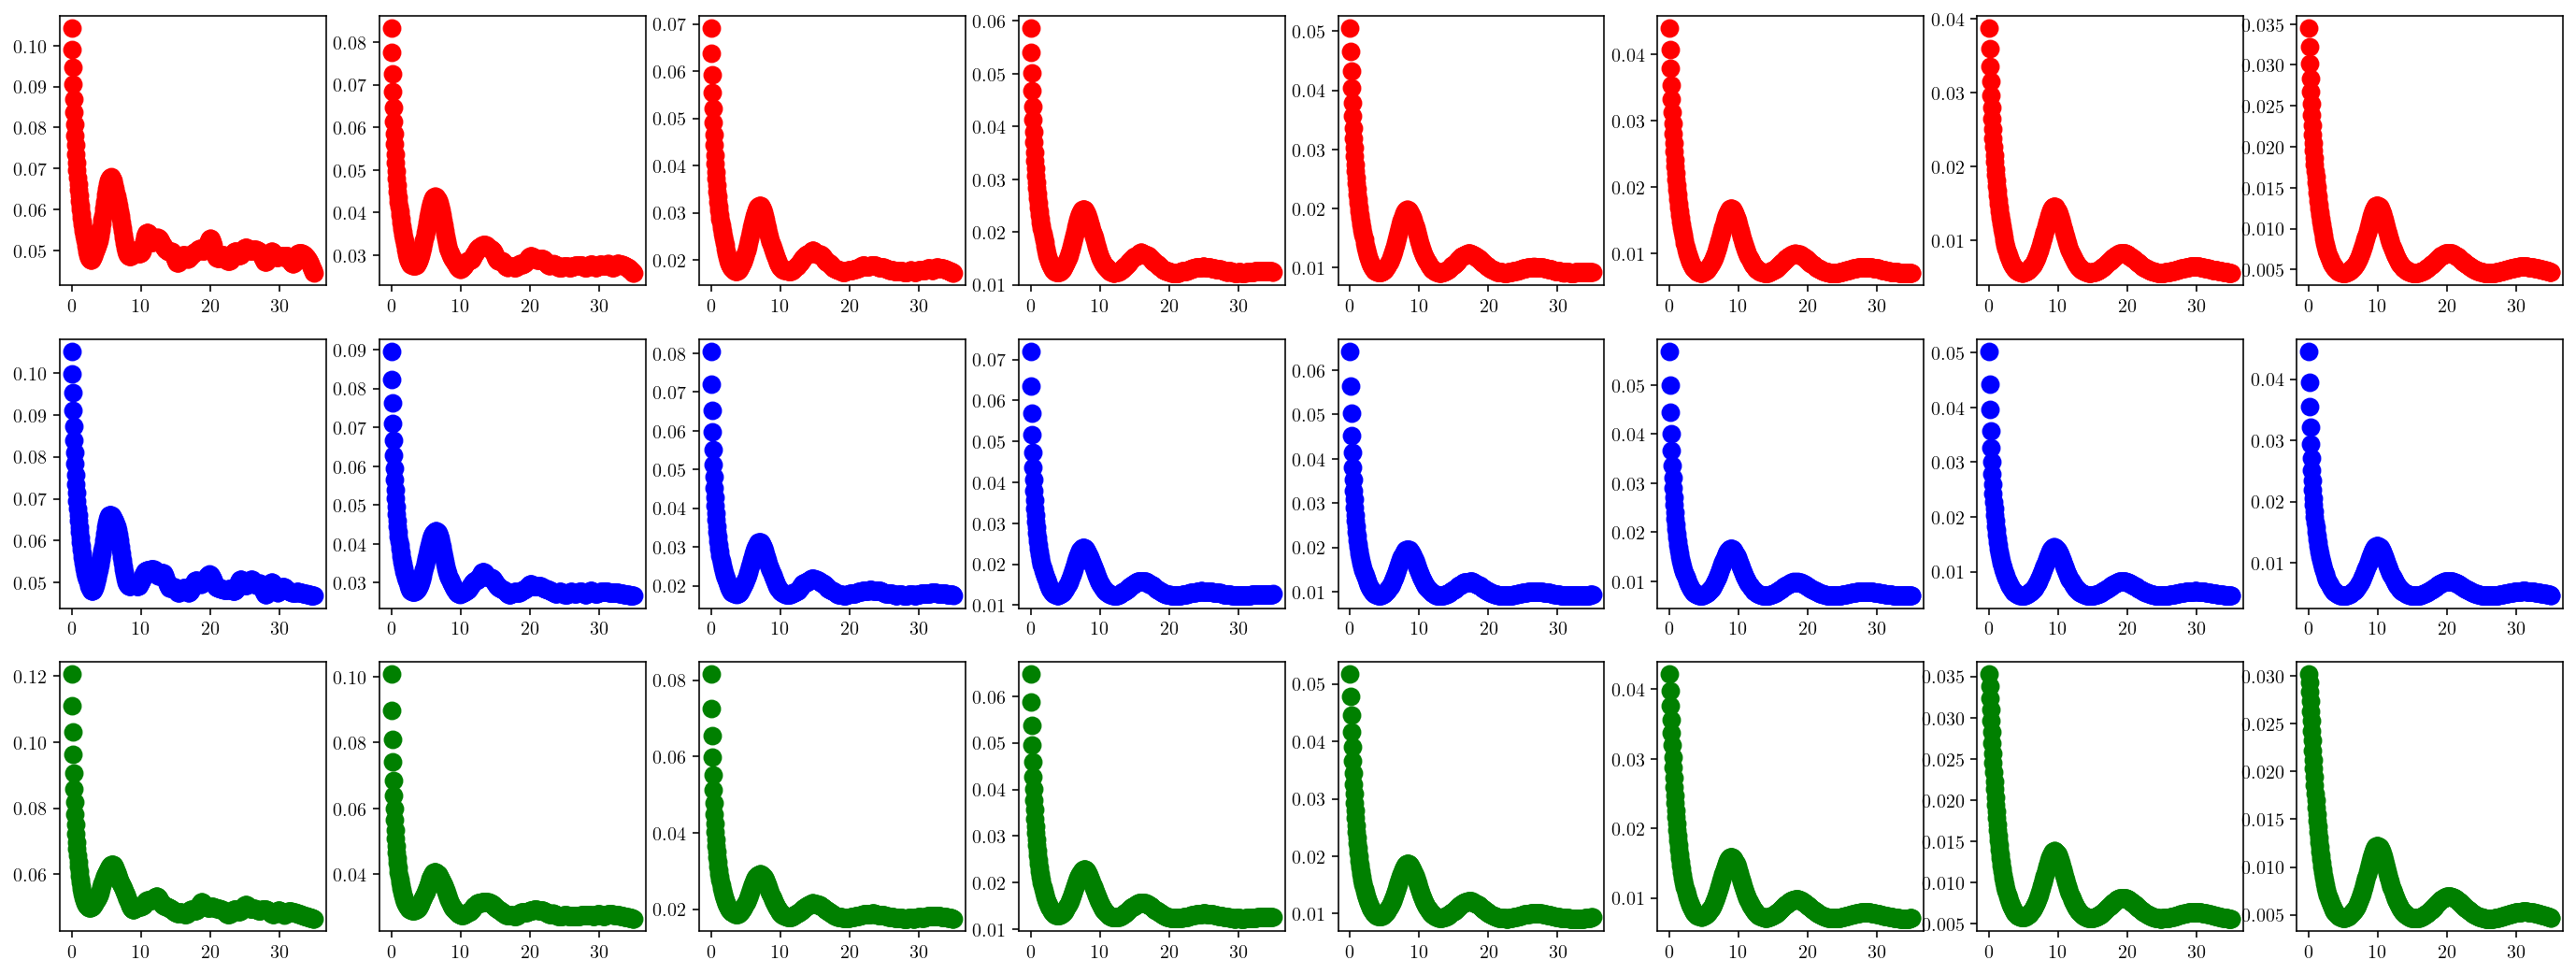

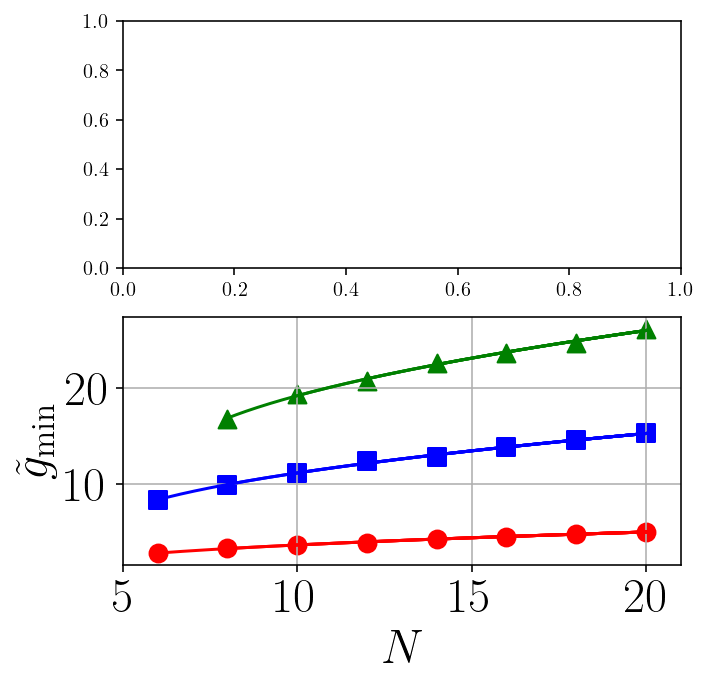

In [13]:
QFI_matrix_smooth = np.zeros((3, len(N_p_list), len(t_vec)))
from scipy.signal import savgol_filter
for i in range(3):
    if i==0:
        for i_N, N_p in enumerate(N_p_list):
            QFI_matrix_smooth[i, i_N] = savgol_filter(QFI_matrix[i_N], 60, 2)
    if i==1:
        for i_N, N_p in enumerate(N_p_list):
            QFI_matrix_smooth[i, i_N] = savgol_filter(QFI_matrix[i_N], 70, 2)
    if i==2:
        for i_N, N_p in enumerate(N_p_list):
            QFI_matrix_smooth[i, i_N] = savgol_filter(QFI_matrix[i_N], 100, 3)



colors = ['red','blue','green']
markers = ['o', 's', '^', 'd']
start = 2

# We plot the results
plt.rcParams["figure.figsize"] = [3*len(N_p_list[start:]), 9]
fig, ax = plt.subplots(3, len(N_p_list[start:]))
marker_size = 80
fs = 24

for i in range(3):
    for i_N, N_p in enumerate(N_p_list[start:]):
        ax[i, i_N].scatter(t_vec, 1/QFI_matrix_smooth[i, i_N+start], marker_size, color=colors[i])

i_min_matrix = []
for i in range(3):
    i_min_matrix.append([argrelextrema(1/np.array(QFI_matrix_smooth[i, i_N]), np.less)[0][i] for i_N, N_p in enumerate(N_p_list)])
print(i_min_matrix)

# We plot the results
plt.rcParams["figure.figsize"] = [5, 5]
fig, ax = plt.subplots(2, 1)
marker_size = 80
fs = 24
ax[1].grid()

for i in range(3):
    if i==2:
        ax[1].scatter(N_p_list[start+1:]/2, t_vec[i_min_matrix[i]][start+1:], marker_size, color=colors[i], marker=markers[i])
    else:
        ax[1].scatter(N_p_list[start:]/2, t_vec[i_min_matrix[i]][start:], marker_size, color=colors[i], marker=markers[i])
    #ax.plot(N_p_list[start:]/2, t_vec[i_min_matrix[i]][start:], '--', color=colors[i])


file = open('data_jc_3rd_revival.p', 'wb')
pickle.dump([N_p_list[start+1:]/2, t_vec[i_min_matrix[2]][start+1:]], file)

# Square root fit

for i in range(3):

    if i==2:
        x = N_p_list[start+1:]/2
        y = t_vec[i_min_matrix[i]][start+1:]
        def f_fit(x, alpha, beta, gamma):
            return alpha*sqrt(x + beta) + gamma
        popt, pcov = curve_fit(f_fit, x, y)
        x_fit = np.linspace(N_p_list[start+1:]/2, N_p_list[-1:]/2, 1000)
        y_fit = f_fit(x_fit, popt[0], popt[1], popt[2])
        ax[1].plot(x_fit, y_fit, '-', color=colors[i])

    else:
        x = N_p_list[start:]/2
        y = t_vec[i_min_matrix[i]][start:]
        def f_fit(x, alpha, beta, gamma):
            return alpha*sqrt(x + beta) + gamma
        popt, pcov = curve_fit(f_fit, x, y)
        x_fit = np.linspace(N_p_list[start:]/2, N_p_list[-1:]/2, 1000)
        y_fit = f_fit(x_fit, popt[0], popt[1], popt[2])
        ax[1].plot(x_fit, y_fit, '-', color=colors[i])


ax[1].set_xlabel(r'$N$', fontsize=fs)
ax[1].set_ylabel(r'$\tilde{g}_{\rm min}$', fontsize=fs)
ax[1].set_xticks(np.arange(5, 25, 5))
ax[1].set_xlim(5, 21)
ax[1].tick_params(axis='both', labelsize=fs)
#ax[1].legend(fontsize=fs, loc='best')

#ax[1].set_ylim(8, 16)

plt.savefig('Figure2_e.svg', bbox_inches='tight', dpi=600)